# CNN 실습 문제 1: ResNeXt, WideResNet 적용하기


## 1. 문제 설명
1. ResNet18 모델의 검증 결과와 ResNeXt18 (32x4d) 모델의 검증 결과를 비교.
2. ResNet18 모델의 검증 결과와 WRN-18-2-bottleneck 모델의 검증 결과를 비교.
3. 조건: 주어진 노트북의 다른 hyperparameter는 변경하지 말고 모델만 변경할 것. 실습 과제 제출시에 사용한 모델과 모든 로그가 담겨 있는 노트북 제출. 모델은 Basic block이 아닌 주어진 Bottleneck block을 사용할 것.

## 2. 목차
1. 필요한 패키지 불러오기 및 parameter 구성하기
2. CIFAR10 데이터 가져오기
3. Trainloader 이미지 살펴보기
4. ResNet, (\*) ResNeXt, (**) WideResNet 정의
5. 모델 학습 및 검증

## 3. 참고자료
1. (ResNet) Deep Residual Learning for Image Recognition, CVPR, 2016 [[ArXiv](https://arxiv.org/pdf/1512.03385)]
2. (*) (ResNeXt) Aggregated Residual Transformations for Deep Neural Networks, CVPR, 2017 [[ArXiv](https://arxiv.org/pdf/1611.05431)]
3. (**) (WideResNet) Wide Residual Networks, ArXiv, 2016 [[ArXiv](https://arxiv.org/pdf/1605.07146)]
4. Referential model code [[torchvision.models](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)]

## 1. 필요한 패키지 불러오기 및 Parameter 구성하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
# Seed 설정 --> 코드를 돌릴때 random값을 동일하게 해주기 위해
random.seed(10)
np.random.seed(123)

# GPU사용을 위한 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 모델 파라미터 설정
config = {'Cifar10_stats': [[0.49139965, 0.48215845, 0.4465309],
                            [0.20220213, 0.19931543, 0.20086348]],
          'batch_size'  : 16,
          'worker'      : 2,
          'epochs'      : 5,
          'momentum'    : 0.9,
          'lr_decay'    : 0.0005,
          'SGD_lr'      : 0.01,
          'Adam_lr'     : 0.001,
          }

cuda


## 2. CIFAR10 데이터 가져오기
CIFAR10의 정규화를 위해 직접 CIFAR10 데이터의 평균과 표준편차를 구해서 Train/Test 데이터셋에 정규화를 적용한다. 

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transforms.ToTensor())
print(f"Trainset 개수: {len(trainset)}, Testset 개수: {len(testset)}")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Trainset 개수: 50000, Testset 개수: 10000


In [3]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in trainset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in trainset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

In [4]:
print("CIFAR10_MEAN:",train_meanR, train_meanG, train_meanB) # Cifar10_stats -> mean
print("CIFAR10_STD:",train_stdR, train_stdG, train_stdB) # Cifar10_stats-> std

CIFAR10_MEAN: 0.49139965 0.48215845 0.4465309
CIFAR10_STD: 0.20220213 0.19931543 0.20086348


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

# apply transform
trainset.transform = train_transforms
testset.transform = test_transforms

# Data Loader
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle = True, num_workers = config['worker'])
testloader = DataLoader(testset, batch_size = config['batch_size'], shuffle = False, num_workers = config['worker'])

# Class_name 저장
with open('./data/cifar-10-batches-py/batches.meta', 'rb') as f:
    batches_meta = pickle.load(f, encoding = 'latin1')
classes_name = list(batches_meta[sorted(list(batches_meta.keys()))[0]]) # airplane, automobile, ..., truck
print(classes_name)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. trainloader 이미지 살펴보기

CIFAR10데이터 가져오기에서 만든 trainloader에 이미지가 어떻게 저장되어있는지 이미지와 라벨을 같이 확인해본다.

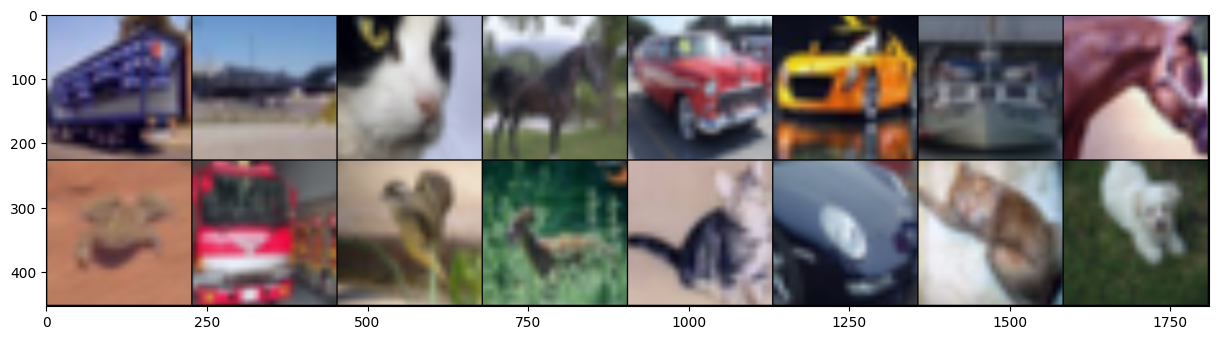

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# trainloader의 이미지 확인
dataiter = iter(trainloader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (15, 5), dpi = 100)
ax = fig.add_subplot(1,1,1)
ax.imshow(torchvision.utils.make_grid(images, normalize = True).permute(1, 2, 0))
plt.show()

# 해당 이미지의 label확인
for i in range(len(images)):
    if (i+1)%8==0:
        print(f'{i+1}: {classes_name[labels[i]]}', end = '\n')
    else:
        if len(classes_name[labels[i]]) >= 6:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '\t')
        else:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '  \t')

## 4. 모델 정의

In [7]:
def conv3x3(in_channels, out_channels, stride=1, groups=1, dilation=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_channels, out_channels, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

1: truck  	2: airplane	3: cat  	4: horse  	5: automobile	6: automobile	7: ship  	8: horse
9: frog  	10: truck  	11: bird  	12: deer  	13: cat  	14: automobile	15: cat  	16: dog


In [32]:
class BottleNeck(nn.Module):
    """ BottleNeck Block Definition
    (hint 1): modify this class __init__()
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None ,groups=1, base_width=64, dilation=1):
        super().__init__()
        

        width = int(out_channels * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(in_channels, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, out_channels * self.expansion)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace= True)
        self.stride = stride

        # self.residual_function = nn.Sequential(
        #     # nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False),
        #     # nn.BatchNorm2d(out_channels),
        #     # nn.ReLU(),
        #     # nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size = 3, padding = 1, bias = False),
        #     # nn.BatchNorm2d(out_channels),
        #     # nn.ReLU(),
        #     # nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size = 1, bias = False),
        #     # nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        #     self.conv1,
        #     self.bn1,
        #     self.relu,
        #     self.conv2,
        #     self.bn2,
        #     self.relu,
        #     self.conv3,
        #     self.bn3

        # )

        # self.relu = nn.ReLU()
        # self.shortcut = nn.Sequential()

        # if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride = stride, kernel_size = 1, bias = False),
        #         nn.BatchNorm2d(out_channels * BottleNeck.expansion)
        #     )
    
    def forward(self, x):
        identity = x
        # x = self.residual_function(x)
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)
        y = self.relu(y)
        y = self.conv3(y)
        y = self.bn3(y)
        if self.downsample is not None:
            identity = self.downsample(x)
        y += identity
        y = self.relu(y)
        # x = self.residual_function(x) + self.shortcut(x)
        # x = self.relu(x)
        return y

class ResNet(nn.Module):
    """ResNet Model Definition
    (hint 2): modify this class __init__()
    """
    def __init__(self, block, num_block, num_classes=10, groups=1, width_per_group=64):
        super().__init__()

        self.in_channels = 64
        self.dilation = 1

        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # self.conv1 = nn.Sequential(
        #     # nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
        #     # nn.BatchNorm2d(64),
        #     # nn.ReLU(),
        #     # nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        #     self.conv1(),
        #     self.bn1(),
        #     self.relu(),
        #     self.maxpool()
        # )

        self.conv2_x = self._make_layer(block, 64, num_block[0], stride=1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], stride=2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], stride=2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], stride=2)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_channels, out_channels * block.expansion, stride),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        # strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, self.groups, self.base_width))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, num_blocks):
            layers.append(
                block(
                    self.in_channels,
                    out_channels,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                )
            )
        # for stride in strides:
        #     layers.append(block(self.in_channels, out_channels, stride))
        #     self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # output = self.conv1(x)
        # output = self.conv2_x(output)
        # x = self.conv3_x(output)
        # x = self.conv4_x(x)
        # x = self.conv5_x(x)
        # x = self.avg_pool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)

        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu(y)
        y = self.maxpool(y)

        y = self.conv2_x(y)
        x = self.conv3_x(y)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet18():
    return ResNet(BottleNeck, [2, 2, 2, 2])

def ResNeXt18():
    """Define your model here"""
    # return ResNet(BottleNeck, [3, 4, 6, 3], groups=32, width_per_group=4)
    return ResNet(BottleNeck, [2, 2, 2, 2], groups=32, width_per_group=4)

def WRN18_2():
    """Define your model here"""
    # return ResNet(BottleNeck, [3 , 4, 6, 3],width_per_group=64*2)
    return ResNet(BottleNeck, [2, 2, 2, 2],width_per_group=64*2)

In [33]:
rn = ResNet18().to(device)
rnx = ResNeXt18().to(device)
wrn = WRN18_2().to(device)


In [34]:
from torchsummary import summary
summary(rn, (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [35]:
summary(rnx, (3, 224, 224), device='cuda')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [36]:
summary(wrn, (3, 224, 224), device='cuda')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## 5. 모델 학습 및 검증

In [37]:
def get_model(model_name):
    if model_name == 'resnet18':
        return ResNet18()
    elif model_name == 'resnext18':
        return ResNeXt18()
    elif model_name == 'wrn-18-2-bottleneck':
        return WRN18_2()
    else:
        raise Exception(f"{model_name} is not supported yet")


for model_name in ['resnet18', 'resnext18', 'wrn-18-2-bottleneck']:
    model = get_model(model_name).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params=model.parameters(), lr = config['SGD_lr'], momentum= config['momentum'], weight_decay=config['lr_decay'])

    for epoch in range(config['epochs']):  # loop over the dataset multiple times

        running_loss = 0.0
        start_time = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            #Time
            end_time = time.time()
            time_taken = end_time - start_time
            time_taken = str(time_taken/60).split('.')
            
        print('Epoch: {}/{}, train_loss: {:.4f}, time:{}m {}s'.format(epoch + 1, config['epochs'], running_loss / len(trainset), time_taken[0], time_taken[1][:2]))

    print(f'Finished Training of {model_name}')

    #Testing Accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the {model_name} on the 10000 test images: {100 * correct / total:.2f}%')

Epoch: 1/5, train_loss: 0.1114, time:5m 80s
Epoch: 2/5, train_loss: 0.0769, time:5m 81s
Epoch: 3/5, train_loss: 0.0616, time:5m 82s
Epoch: 4/5, train_loss: 0.0523, time:5m 82s
Epoch: 5/5, train_loss: 0.0461, time:5m 82s
Finished Training of resnet18
Accuracy of the resnet18 on the 10000 test images: 72.49%
Epoch: 1/5, train_loss: 0.1032, time:7m 73s
Epoch: 2/5, train_loss: 0.0667, time:7m 74s
Epoch: 3/5, train_loss: 0.0524, time:7m 73s
Epoch: 4/5, train_loss: 0.0437, time:7m 75s
Epoch: 5/5, train_loss: 0.0384, time:7m 74s
Finished Training of resnext18
Accuracy of the resnext18 on the 10000 test images: 78.22%
Epoch: 1/5, train_loss: 0.1045, time:10m 93s
Epoch: 2/5, train_loss: 0.0676, time:10m 94s
Epoch: 3/5, train_loss: 0.0539, time:10m 93s
Epoch: 4/5, train_loss: 0.0462, time:10m 94s
Epoch: 5/5, train_loss: 0.0416, time:10m 95s
Finished Training of wrn-18-2-bottleneck
Accuracy of the wrn-18-2-bottleneck on the 10000 test images: 76.79%


In [ ]:
a